In [19]:
# # for colab environment
# from google.colab import drive
# !ls /content/drive/MyDrive/projects/ML_FinalProj
# import sys
# import os

# drive.mount('/content/drive')

# sys.path.append('/content/drive/MyDrive/projects/ML_FinalProj')

# os.chdir("/content/drive/MyDrive/projects/ML_FinalProj")

DataPreprocessing.ipynb  MLProject_Progress.ipynb     ModelTraining.ipynb
dataset			 MLTeamPredictionBasic.ipynb  zips
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
from pathlib import Path
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


In [21]:
ROOT = Path("dataset")
TEAM_STAT_PATH = ROOT / "team-stat"
GAME_LOG_PATH = ROOT / "game-log"
PITCHER_PATH = ROOT / "pitcher" / "sp_yearly_game"

DATA_PATH = ROOT / "processed" / "final_dataset_with_diff_v1.csv"

final_df_complete = pd.read_csv(DATA_PATH)


In [22]:
# train/test set 생성

GLOBAL_RANDOM_SEED = 42

df_train_val, df_test = train_test_split(
    final_df_complete,
    test_size=0.1,
    random_state=GLOBAL_RANDOM_SEED,
    shuffle=True
)

df_train_val = df_train_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(f"Global Train+Val Set shape: {df_train_val.shape}")
print(f"Global Test Set shape: {df_test.shape}")

Global Train+Val Set shape: (12844, 392)
Global Test Set shape: (1428, 392)


In [31]:
# Baseline model

# 1. Zero-R Baseline (무조건 홈 승리 예측)
# 테스트 셋의 모든 결과를 홈 승리로 예측
preds_dummy = np.ones(len(df_test))
accuracy_dummy = accuracy_score(df_test['home_win'], preds_dummy)

print(f"\n[Baseline 1: 무조건 홈 승리]")
print(f"Accuracy: {accuracy_dummy:.4f}")

# 2. Simple Rule Baseline (승률 비교)
# 승률 높은 팀이 승리한다고 예측
preds_rule = (df_test['home_in_season_win_rate'] > df_test['away_in_season_win_rate']).astype(int)

accuracy_rule = accuracy_score(df_test['home_win'], preds_rule)

print(f"\n[Baseline 2: 승률 높은 팀 승리]")
print(f"Accuracy: {accuracy_rule:.4f}")



전체 데이터 중 홈 승리 비율: 0.5147

[Baseline 1: 무조건 홈 승리]
Accuracy: 0.4993

[Baseline 2: 승률 높은 팀 승리]
Accuracy: 0.5749


In [33]:
# Baseline model

# 3. ERA 단순 비교 모델
# 단순 선발 ERA 더 낮은 팀 승리 예측
preds_era_rule = (df_test['home_era'] < df_test['away_era']).astype(int)

accuracy_era_rule = accuracy_score(df_test['home_win'], preds_era_rule)

print(f"\n[Baseline 3: 선발 ERA 더 낮은 팀 승리]")
print(f"Accuracy (정확도): {accuracy_era_rule:.4f}")


# 4. ERA 2개만 사용한 Logistic Regression
X_cols_era = ['home_era', 'away_era']

X_train_era = df_train_val[X_cols_era]
y_train_era = df_train_val['home_win']

X_test_era = df_test[X_cols_era]
y_test_era = df_test['home_win']

# 모델 학습
model_era_lr = LogisticRegression(random_state=GLOBAL_RANDOM_SEED)
model_era_lr.fit(X_train_era, y_train_era)

# 평가
preds_era_lr = model_era_lr.predict(X_test_era)
accuracy_era_lr = accuracy_score(y_test_era, preds_era_lr)

print(f"\n[Baseline 4: ERA Only Logistic Regression]")
print(f"Accuracy (정확도): {accuracy_era_lr:.4f}")


[Baseline 3: 선발 ERA 더 낮은 팀 승리]
Accuracy (정확도): 0.6317

[Baseline 4: ERA Only Logistic Regression]
Accuracy (정확도): 0.6345
Coefficients: [[-0.2482885   0.25380447]]


In [23]:
# baseline model
# 간단한 logistic regression 기반 모델
# 두 팀 간의 차이만을 학습

diff_cols = [col for col in final_df_complete.columns if col.startswith('diff_')]


X_train_base = df_train_val[diff_cols]
y_train_base = df_train_val['home_win']

X_test_base = df_test[diff_cols]
y_test_base = df_test['home_win']

# 모델 정의(logistic regression 이용)
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=RANDOM_SEED, max_iter=1000))
])

# 모델 학습
baseline_model.fit(X_train_base, y_train_base)

# 모델 평가
preds_base = baseline_model.predict(X_test_base)
pred_probs_base = baseline_model.predict_proba(X_test_base)[:, 1]

accuracy_base = accuracy_score(y_test_base, preds_base)
roc_auc_base = roc_auc_score(y_test_base, pred_probs_base)
logloss_base = log_loss(y_test_base, pred_probs_base)

print(f"\n[Test Set 평가 결과]")
print(f"Accuracy (정확도): {accuracy_base:.4f}")
print(f"ROC AUC: {roc_auc_base:.4f}")
print(f"Log Loss: {logloss_base:.4f}")



[Test Set 평가 결과]
Accuracy (정확도): 0.6478
ROC AUC: 0.6922
Log Loss: 0.6388


In [28]:
# baseline model
# logistic regression, 이번에는 diff 없는 기본 데이터만 전부 활용
raw_cols = [col for col in final_df_complete.columns if col.startswith('home_') or col.startswith('away_')]

exclude_cols = ['home_win', 'home_runs', 'away_runs', 'home_id', 'away_id', 'year']
X_cols_raw = [c for c in raw_cols if c not in exclude_cols]

print(f"Selected Raw Features: {len(X_cols_raw)} columns")


X_train_raw = df_train_val[X_cols_raw]
y_train_raw = df_train_val['home_win']

X_test_raw = df_test[X_cols_raw]
y_test_raw = df_test['home_win']


baseline_raw_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=GLOBAL_RANDOM_SEED, max_iter=1000))
])


# 4. 모델 학습
baseline_raw_model.fit(X_train_raw, y_train_raw)


# 5. 모델 평가
preds_raw = baseline_raw_model.predict(X_test_raw)
pred_probs_raw = baseline_raw_model.predict_proba(X_test_raw)[:, 1]

accuracy_raw = accuracy_score(y_test_raw, preds_raw)
roc_auc_raw = roc_auc_score(y_test_raw, pred_probs_raw)
logloss_raw = log_loss(y_test_raw, pred_probs_raw)

print(f"\n[Baseline (Raw Data) Test Set 평가 결과]")
print(f"Accuracy (정확도): {accuracy_raw:.4f}")
print(f"ROC AUC: {roc_auc_raw:.4f}")
print(f"Log Loss: {logloss_raw:.4f}")


Selected Raw Features: 256 columns

[Baseline (Raw Data) Test Set 평가 결과]
Accuracy (정확도): 0.6429
ROC AUC: 0.6830
Log Loss: 0.6434


In [24]:
# XGBoost
# 전체 feature 중 영향력 top-20 feature 선별하여 학습

drop_cols = ['date', 'season', 'home_id', 'away_id', 'home_runs', 'away_runs', 'home_win']
cols_to_drop = [c for c in drop_cols if c in df_train_val.columns]

X_train_val_all = df_train_val.drop(columns=cols_to_drop)
y_train_val_all = df_train_val['home_win']

X_test_new = df_test.drop(columns=cols_to_drop)
y_test_new = df_test['home_win']

# 영향력 확인 위함
model_xgb_all = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=400,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_SEED
)

model_xgb_all.fit(
    X_train_xgb, y_train_xgb,
    eval_set=[(X_val_xgb, y_val_xgb)],
    verbose=False
)
# 영향력 높은 feature 20개 선택해 새 dataset 정의
booster = model_xgb_all.get_booster()
imp = booster.get_score(importance_type='gain')
if len(imp) > 0 and all(k.startswith('f') for k in imp.keys()):
    name_map = {f"f{i}": n for i, n in enumerate(X_train_xgb.columns)}
    imp_named = {name_map[k]: v for k, v in imp.items() if k in name_map}
else:
    imp_named = imp

imp_series = pd.Series(imp_named, dtype=float).reindex(X_train_xgb.columns).fillna(0.0)
top_features = imp_series.sort_values(ascending=False).head(20).index.tolist()
print(f"Top20 features: {top_features}")

X_train_top = X_train_xgb[top_features]
X_val_top   = X_val_xgb[top_features]
X_test_top  = X_test_xgb[top_features]
# 선택한 feature 기반 학습
model_xgb_top20 = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=100,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_SEED
)
model_xgb_top20.fit(
    X_train_top, y_train_xgb,
    eval_set=[(X_val_top, y_val_xgb)],
    verbose=False
)

preds = model_xgb_top20.predict(X_test_top)
probs = model_xgb_top20.predict_proba(X_test_top)[:, 1]

print("\n[Test Set 평가 결과]")
print(f"Accuracy: {accuracy_score(y_test_xgb, preds):.4f}")
print(f"ROC AUC : {roc_auc_score(y_test_xgb, probs):.4f}")
print(f"LogLoss : {log_loss(y_test_xgb, probs):.4f}")


Top20 features: ['diff_era', 'home_RA9_decay', 'home_XH/AB_decay', 'away_R/ePA_decay', 'diff_OPS_decay', 'away_FIP_decay', 'away_BABIP.y_decay', 'away_OBP.y_decay', 'away_K%.y_decay', 'diff_PA.x_decay', 'home_ER_decay', 'away_OPS_decay', 'home_RPW.y_decay', 'away_HR_decay', 'diff_R.x_decay', 'home_BABIP.x_decay', 'home_ERA-_decay', 'home_FIP-_decay', 'home_rRA_decay', 'diff_WAA-GR_decay']

[Test Set 평가 결과]
Accuracy: 0.6359
ROC AUC : 0.6840
LogLoss : 0.6407


In [25]:
# weighted soft voting
# 투구/타격/수비/이외/해당년도전적 + diff 10개모델
######## ERA 포함안한모델

drop_cols = ['date', 'season', 'home_id', 'away_id', 'home_runs', 'away_runs', 'home_win']
cols_to_drop = [c for c in drop_cols if c in df_train_val.columns]

X_train_val_all = df_train_val.drop(columns=cols_to_drop)
y_train_val_all = df_train_val['home_win']

X_test_new = df_test.drop(columns=cols_to_drop)
y_test_new = df_test['home_win']

# sub-model 별 feature 목록
offense_base = ['WAR.x_decay', 'oWAR_decay', 'wRC+_decay', 'wOBA_decay', 'OPS_decay', 'wRC_decay', 'AVG.x_decay', 'OBP.x_decay', 'SLG_decay', 'IsoP_decay', 'BB%.x_decay', 'HR.x_decay', 'RBI_decay', 'RC27_decay']
pitching_base = ['WAR.y_decay', '선발WAR_decay', '구원WAR_decay', 'FIP_decay', 'kwERA_decay', 'ERA_decay', 'WHIP_decay', 'K/9_decay', 'BB/9_decay', 'K%.y_decay', 'BB%.y_decay', 'FIP-_decay', 'ERA-_decay', 'LOB_decay', 'HR/9_decay', 'IP_decay', 'GS_decay', 'GR_decay']
defense_base = ['dWAR_decay', '필딩 RAA_decay', 'Range RAA_decay', '수비 RAA_decay', '포지션 RAA_decay', 'E_decay']
others_base = ['Rep.Wins_decay', 'Pos.Wins_decay', 'RAR_decay']
momentum_base = ['in_season_win_rate', 'L10_win_rate']

# Home/Away
offense_features = [f'home_{c}' for c in offense_base] + [f'away_{c}' for c in offense_base]
pitching_features = [f'home_{c}' for c in pitching_base] + [f'away_{c}' for c in pitching_base]
defense_features = [f'home_{c}' for c in defense_base] + [f'away_{c}' for c in defense_base]
others_features = [f'home_{c}' for c in others_base] + [f'away_{c}' for c in others_base]
momentum_features = [f'home_{c}' for c in momentum_base] + [f'away_{c}' for c in momentum_base]
# Diff
diff_offense_features = [f'diff_{c}' for c in offense_base]
diff_pitching_features = [f'diff_{c}' for c in pitching_base]
diff_defense_features = [f'diff_{c}' for c in defense_base]
diff_others_features = [f'diff_{c}' for c in others_base]
diff_momentum_features = [f'diff_{c}' for c in momentum_base]


# sub-model 정의
# 지표별 개별 트리 10개
common_dt_params = {
    'max_depth': 4,
    'min_samples_leaf': 20,
    'random_state': RANDOM_SEED
}

pipe_offense = Pipeline([('s', ColumnTransformer([('p', 'passthrough', offense_features)], remainder='drop')), ('m', DecisionTreeClassifier(**common_dt_params))])
pipe_pitching = Pipeline([('s', ColumnTransformer([('p', 'passthrough', pitching_features)], remainder='drop')), ('m', DecisionTreeClassifier(**common_dt_params))])
pipe_defense = Pipeline([('s', ColumnTransformer([('p', 'passthrough', defense_features)], remainder='drop')), ('m', DecisionTreeClassifier(**common_dt_params))])
pipe_others = Pipeline([('s', ColumnTransformer([('p', 'passthrough', others_features)], remainder='drop')), ('m', DecisionTreeClassifier(**common_dt_params))])
pipe_momentum = Pipeline([('s', ColumnTransformer([('p', 'passthrough', momentum_features)], remainder='drop')), ('m', DecisionTreeClassifier(**common_dt_params))])
pipe_diff_offense = Pipeline([('s', ColumnTransformer([('p', 'passthrough', diff_offense_features)], remainder='drop')), ('m', DecisionTreeClassifier(**common_dt_params))])
pipe_diff_pitching = Pipeline([('s', ColumnTransformer([('p', 'passthrough', diff_pitching_features)], remainder='drop')), ('m', DecisionTreeClassifier(**common_dt_params))])
pipe_diff_defense = Pipeline([('s', ColumnTransformer([('p', 'passthrough', diff_defense_features)], remainder='drop')), ('m', DecisionTreeClassifier(**common_dt_params))])
pipe_diff_others = Pipeline([('s', ColumnTransformer([('p', 'passthrough', diff_others_features)], remainder='drop')), ('m', DecisionTreeClassifier(**common_dt_params))])
pipe_diff_momentum = Pipeline([('s', ColumnTransformer([('p', 'passthrough', diff_momentum_features)], remainder='drop')), ('m', DecisionTreeClassifier(**common_dt_params))])


estimators_list = [
    ('offense_tree', pipe_offense),
    ('pitching_tree', pipe_pitching),
    ('defense_tree', pipe_defense),
    ('others_tree', pipe_others),
    ('momentum_tree', pipe_momentum),
    ('diff_offense_tree', pipe_diff_offense),
    ('diff_pitching_tree', pipe_diff_pitching),
    ('diff_defense_tree', pipe_diff_defense),
    ('diff_others_tree', pipe_diff_others),
    ('diff_momentum_tree', pipe_diff_momentum)
]

# 현재는 해당년도 전적에 높은 가중치 들어간 상태
# 조절해 보아도 유의미한 차이는 없었음
manual_weights = [0.05, 0.05, 0.05, 0.05, 0.30, 0.05, 0.05, 0.05, 0.05, 0.30]

# 최종 모델 정의
# soft voting, 수동 가중치
voting_model_manual = VotingClassifier(
    estimators=estimators_list,
    voting='soft',
    weights=manual_weights,
    n_jobs=-1
)

# 학습
voting_model_manual.fit(X_train_new, y_train_new)

# 모델 평가
preds_manual = voting_model_manual.predict(X_test_new)
pred_probs_manual = voting_model_manual.predict_proba(X_test_new)[:, 1]

accuracy_manual = accuracy_score(y_test_new, preds_manual)
roc_auc_manual = roc_auc_score(y_test_new, pred_probs_manual)
logloss_manual = log_loss(y_test_new, pred_probs_manual)

print(f"\n[Test Set 평가 결과]")
print(f"Accuracy (정확도): {accuracy_manual:.4f}")
print(f"ROC AUC: {roc_auc_manual:.4f}")
print(f"Log Loss: {logloss_manual:.4f}")


[Test Set 평가 결과]
Accuracy (정확도): 0.5616
ROC AUC: 0.5820
Log Loss: 0.6858


In [26]:
# weighted soft voting
# ERA에 강한 가중치 부여
drop_cols = ['date', 'season', 'home_id', 'away_id', 'home_runs', 'away_runs', 'home_win']
cols_to_drop = [c for c in drop_cols if c in df_train_val.columns]

X_train_val_all = df_train_val.drop(columns=cols_to_drop)
y_train_val_all = df_train_val['home_win']

X_test_new = df_test.drop(columns=cols_to_drop)
y_test_new = df_test['home_win']

era_features_home = ['home_era']
era_features_away = ['away_era']
era_features_diff = ['diff_era']

# pipeline 생성
pipe_home_era = Pipeline([
    ('s', ColumnTransformer([('p', 'passthrough', era_features_home)], remainder='drop')),
    ('m', DecisionTreeClassifier(**common_dt_params))
])

pipe_away_era = Pipeline([
    ('s', ColumnTransformer([('p', 'passthrough', era_features_away)], remainder='drop')),
    ('m', DecisionTreeClassifier(**common_dt_params))
])

pipe_diff_era = Pipeline([
    ('s', ColumnTransformer([('p', 'passthrough', era_features_diff)], remainder='drop')),
    ('m', DecisionTreeClassifier(**common_dt_params))
])

# 기존 Estimator 리스트에 ERA 모델 추가
# 기존 10개 모델 + ERA 모델 3개 = 총 13개 모델
estimators_list_with_era = estimators_list + [
    ('home_era_tree', pipe_home_era),
    ('away_era_tree', pipe_away_era),
    ('diff_era_tree', pipe_diff_era)
]

# ERA에 집중
new_manual_weights = [
    0.02, 0.02, 0.02, 0.02, 0.1,
    0.02, 0.02, 0.02, 0.02, 0.1,
    0.3, 0.3, 0.5
]

# 모델 학습
voting_model_era = VotingClassifier(
    estimators=estimators_list_with_era,
    voting='soft',
    weights=new_manual_weights,
    n_jobs=-1
)

voting_model_era.fit(X_train_new, y_train_new)

# 평가
preds_era = voting_model_era.predict(X_test_new)
pred_probs_era = voting_model_era.predict_proba(X_test_new)[:, 1]

accuracy_era = accuracy_score(y_test_new, preds_era)
roc_auc_era = roc_auc_score(y_test_new, pred_probs_era)
logloss_era = log_loss(y_test_new, pred_probs_era)

print(f"\n[Test Set 평가 결과 - ERA Weighted]")
print(f"Accuracy (정확도): {accuracy_era:.4f}")
print(f"ROC AUC: {roc_auc_era:.4f}")
print(f"Log Loss: {logloss_era:.4f}")

Training Voting Classifier with Strong ERA Weights...

[Test Set 평가 결과 - ERA Weighted]
Accuracy (정확도): 0.6429
ROC AUC: 0.6882
Log Loss: 0.6497


Training Bagging Models with 384 features...

[Model 1: Custom Bagging Classifier]
Accuracy: 0.6366
ROC AUC : 0.6821

[Model 2: Random Forest]
Accuracy: 0.6373
ROC AUC : 0.6742
Log Loss: 0.6538


/tmp/ipython-input-4253860762.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20_imp.values, y=top_20_imp.index, palette='viridis')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44201 (\N{HANGUL 

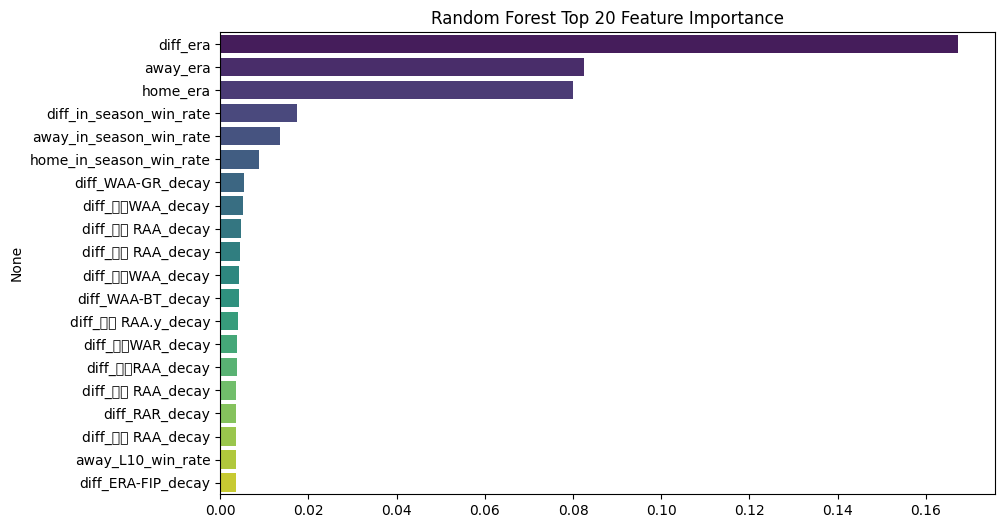

In [36]:
# custom bagging + random forest

drop_cols = ['date', 'season', 'year', 'home_id', 'away_id', 'home_runs', 'away_runs', 'home_win']
cols_to_drop = [c for c in drop_cols if c in df_train_val.columns]

X_train_bag = df_train_val.drop(columns=cols_to_drop)
y_train_bag = df_train_val['home_win']

X_test_bag = df_test.drop(columns=cols_to_drop)
y_test_bag = df_test['home_win']

# 결측치처리
imputer = SimpleImputer(strategy='constant', fill_value=0)
X_train_bag = pd.DataFrame(imputer.fit_transform(X_train_bag), columns=X_train_bag.columns)
X_test_bag = pd.DataFrame(imputer.transform(X_test_bag), columns=X_test_bag.columns)

print(f"Training Bagging Models with {X_train_bag.shape[1]} features...")


# custom bagging
#  학습 데이터의 70%만 무작위로 뽑아서 각 트리를 학습 (다양성 확보)
#  Feature의 80%만 무작위로 뽑아서 학습 (Feature Bagging)
#  100개의 트리를 만들어 voting

bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=5, min_samples_leaf=10), # 너무 깊지 않은 트리 (Overfitting 방지)
    n_estimators=100,
    max_samples=0.7,   # Row Sampling (Bootstrap)
    max_features=0.8,  # Column Sampling (Feature Bagging)
    bootstrap=True,
    bootstrap_features=False,
    n_jobs=-1,
    random_state=42
)

# 학습
bagging_model.fit(X_train_bag, y_train_bag)

# 평가
preds_bag = bagging_model.predict(X_test_bag)
probs_bag = bagging_model.predict_proba(X_test_bag)[:, 1]

print(f"\n[Model 1: Custom Bagging Classifier]")
print(f"Accuracy: {accuracy_score(y_test_bag, preds_bag):.4f}")
print(f"ROC AUC : {roc_auc_score(y_test_bag, probs_bag):.4f}")



#### random forest


rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

# 학습
rf_model.fit(X_train_bag, y_train_bag)

# 평가
preds_rf = rf_model.predict(X_test_bag)
probs_rf = rf_model.predict_proba(X_test_bag)[:, 1]

print(f"\n[Model 2: Random Forest]")
print(f"Accuracy: {accuracy_score(y_test_bag, preds_rf):.4f}")
print(f"ROC AUC : {roc_auc_score(y_test_bag, probs_rf):.4f}")
print(f"Log Loss: {log_loss(y_test_bag, probs_rf):.4f}")

# Feature Importance 확인 (Random Forest)
import matplotlib.pyplot as plt
import seaborn as sns

imp_series = pd.Series(rf_model.feature_importances_, index=X_train_bag.columns)
top_20_imp = imp_series.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_20_imp.values, y=top_20_imp.index, palette='viridis')
plt.title('Random Forest Top 20 Feature Importance')
plt.show()